In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import tensorflow as tf

# cifar10
from tensorflow.keras import datasets, layers, models

import matplotlib.pyplot as plt
import numpy as np

In [10]:
# Recreate the exact same model, including its weights and the optimizer
#model = tf.keras.models.load_model(r'..\..\..\build\saved_model\Simple_CNN\HDF5\Simple_CN.h5', compile=True)
model = tf.keras.models.load_model(r'/content/drive/Othercomputers/PC/msc_final_project/TPU/build/saved_model/Simple_CNN/HDF5/Simple_CN.h5', compile=True)

# Show the model architecture
#model.summary()



In [11]:
# Utility functions
def print_shapes(train_images, test_images, train_labels, test_labels):
  print(f"train_images: {train_images.shape}\n"\
      f"test_images: {test_images.shape}\n"\
      f"train_labels: {train_labels.shape}\n"\
      f"test_labels: {test_labels.shape}\n")

In [5]:
# Load the image
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

170508288/170498071 [==============================] - 11s 0us/step


In [6]:
# Preprocessing images and labels
height, width, channels = 32, 32, 3
nb_classes = 10 
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
               'horse', 'ship', 'truck']


train_images = train_images.reshape((-1, height, width, channels))
test_images = test_images.reshape((-1, height, width, channels))

train_labels = tf.keras.utils.to_categorical(train_labels, nb_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, nb_classes)

print_shapes(train_images, test_images, train_labels, test_labels)

train_images: (50000, 32, 32, 3)
test_images: (10000, 32, 32, 3)
train_labels: (50000, 10)
test_labels: (10000, 10)



In [7]:
loss_object = tf.keras.losses.CategoricalCrossentropy()


# Function to calculate adversary noise
def generate_adversary(image, label):
  image = tf.cast(image, tf.float32)

  with tf.GradientTape() as tape:
    tape.watch(image)
    prediction = model(image)[0]
    loss = loss_object(label, prediction)
  gradient = tape.gradient(loss, image)
  sign_grad = tf.sign(gradient)

  return sign_grad

Prediction from CNN: frog


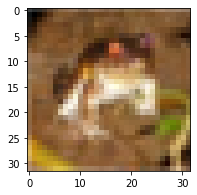

In [12]:
# Selecting random image for testing
rand_idx = 0
image = train_images[rand_idx].reshape((1, height, width, channels))
label = train_labels[rand_idx]

print(f'Prediction from CNN: {label_names[np.where(label==1)[0][0]]}')
plt.figure(figsize=(3,3))
plt.imshow(image.reshape((height, width, channels)))
plt.show()

In [13]:
# Adding the adversary noise to image
perturbations = generate_adversary(image,label).numpy()
adversarial = image + (perturbations * 0.15)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


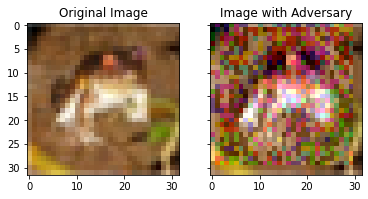

In [14]:
# Comparing both images 
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(image.reshape(height,width, channels))
ax1.set_title("Original Image")
ax2.imshow(adversarial.reshape(height,width, channels))
ax2.set_title("Image with Adversary")
plt.show()

In [15]:
# Comparing predictions
print(f'Normal Image Prediction: {label_names[model.predict(image).argmax()]}')
print(f"Adversary Prediction: {label_names[model.predict(adversarial).argmax()]}")

Normal Image Prediction: frog
Adversary Prediction: cat


## 4    create a adversary noise set and test the model right rate

In [16]:
# Function to calculate adversary noise
def generate_adversary_image(image, label, epsilon):

  '''Directly add the adversarial noise to the image

  Args:
    image: a image but need to be reshaped to  [1, height, width, channels]
    label: label from xxxx_labels[i]
           {array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}
           {numpy.ndarray}
    epsilon: int number of epsilon
             {1}


  Returns:
    A tensor of shape [1, height, width, channels]
  '''

  # Change the image to a tensor
  image_tf = tf.cast(image, tf.float32)

  #record gradients
  with tf.GradientTape() as tape:
    
    tape.watch(image_tf)

    prediction = model(image_tf)
    loss = tf.keras.losses.MSE(label, prediction)
    
  gradient = tape.gradient(loss, image_tf)
  sign_grad = tf.sign(gradient)
  sign_grad = sign_grad.numpy()

  adversarial = image + (sign_grad * epsilon)

  

  return adversarial

### 4.1 Use test_images for test

In [18]:
def create_adversarty_images_set(image_set, label_set, total_label, epsilon):
    '''A script to create adversarial images set

    Args:
        image_set: image set which need to be adversarized. shape like (len(image_set), height, width, channels)
        label_set: label set of the image set.  shape like (len(image_set), nb_classes)
        total_label: whole label set
        epsilon: int number of epsilon

    Returns:
        adversarial_images_set: adversarial images set. shape like (len(image_set), height, width, channels)
    '''


    right_count_original = 0
    right_count_adversary = 0

    for i in range(len(image_set)):
        image = image_set[i].reshape((1, height, width, channels))
        label = label_set[i]

        #label_name_original = total_label[np.where(label==1)[0][0]]
        label_original = np.where(label==1)[0][0]
        

        #   Create adversarial image (adding noise to original image)
        adversarial = generate_adversary_image(image, label, epsilon)

        #orig_pred_name = total_label[model(image).numpy().argmax()]
        orig_pred = model(image).numpy().argmax()

        #adversarial_pred_name = total_label[model(adversarial).numpy().argmax()]      
        adversarial_pred = model(adversarial).numpy().argmax()


        #   calculate accuracy of original image
        if orig_pred == label_original:
            right_count_original += 1  

        if adversarial_pred == label_original:
            right_count_adversary += 1
    

    accuary_original = right_count_original/len(image_set)
    accuary_adv = right_count_adversary/len(image_set)

    print(f'epsilon: {epsilon}')    
    print(f'Accuracy of original image before attack: {accuary_original}')
    print(f'Accuracy of original image after attack {accuary_adv}')

    return f"'epsilon': {epsilon}, 'accuary_original': {accuary_original}, 'accuary_adv': {accuary_adv}"

### 4.2 Create a script to store information about different input value

In [19]:
epsilons = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

In [20]:
def test_different_input_epsilon(image_set, image_label_set, label_names_set, epsilons, store_file_path):
  for i, epsilon in enumerate(epsilons):
    
    information = create_adversarty_images_set(image_set, image_label_set, label_names, epsilon)

    with open(store_file_path, 'a') as f:
      f.write(information + '\n')



In [21]:
test_different_input_epsilon(test_images, test_labels, label_names, epsilons, '/content/drive/Othercomputers/PC/msc_final_project/TPU/attack/whitebox/FSGM/information/Simple_CNN_Information.txt')

epsilon: 0
Accuracy of original image before attack: 0.6281
Accuracy of original image after attack 0.6281
epsilon: 0.01
Accuracy of original image before attack: 0.6281
Accuracy of original image after attack 0.3183
epsilon: 0.05
Accuracy of original image before attack: 0.6281
Accuracy of original image after attack 0.0192
epsilon: 0.1
Accuracy of original image before attack: 0.6281
Accuracy of original image after attack 0.0097
epsilon: 0.15
Accuracy of original image before attack: 0.6281
Accuracy of original image after attack 0.0138
epsilon: 0.2
Accuracy of original image before attack: 0.6281
Accuracy of original image after attack 0.0152
epsilon: 0.25
Accuracy of original image before attack: 0.6281
Accuracy of original image after attack 0.0232
epsilon: 0.3
Accuracy of original image before attack: 0.6281
Accuracy of original image after attack 0.0312
